Table of Contents
1.	Introduction
2.	Mathematical Model  
    A. The choice of the Data  
    B. Tradeoff in weighing students' adaptability  
3.	Solution
4.	Results and Discussion
5.	Conclusion
6.	Appendix


# 1. Introduction

Since every student is able to indicate their preferences for dormitory and roommate, our passion is to build up a better assignment system to get a better sense of the student’s preferences. This helps us find the best possible match for each student. The objective of our project is to rationalize the assignment and maximize their satisfaction based on certain constraints and rules, such as capacity of the halls, room availability, distance to the department buildings and the gender of students. The preference options for students also can be counted as a big factor including the most acceptable price, the floor level, and the canteen. In this model, we will consider how much weight a student will value each aspect of a dormitory. For convenience, the data of student's preference and dormitory attributes will be created randomly.

# 2.	Mathematical Model

## A. The choice of the Data

Due to no accessibility of UW-Madison's Housing system and conveniece, we implement a data generator in replacement of certain parameters. With the help of 'Distrubutions', we crate a function to adapt the dorm adaptbility. In this model, we desires datas as close as possible so we listed as many data we can think of, and endow them with our desirable distribution.  
Below are the random parameteres that we set for the residence hall's attributes and their distribution.

| Dorm attribute |   Distribution   | Data Type |
| -------------  |:--------------:  | ---------:|
| floor          | Uniform(1, 6)    | int       |
| price          | Normal(1000, 100)| int       |
| capacity       | Uniform(1, 5)    | int       |
| canteen        | Bernoulli(0.5)   | bool      |

The floor is distributed uniformly so our model use the uniform distribution to forge the parameters and we take the highest floor to be 6 as default. For the price we considered that the average rent for housing is around 4400 per semester.  
[UW-Madison Housing Price,https://www.housing.wisc.edu/residence-halls/billing/quarterly-rates]  
The capacity of a dorm is uiformily distributed between 1 and 5. For the canteen, It could be either close to a canteen or miles away, so we create a Bernoulli distrubution to express the value.  
Below are the random parameteres that we set for the students information and its distribution.

| Student Attribute  |   Distribution    | Data Type |
| -------------  |:-----------------:| ---------:|
| gender         | Bernoulli(0.5)*2-1| 1 or -1   |
| floor          | Uniform(1, 6)     | int       |
| price          | Normal(1000, 100) | int       |
| capacity       | Uniform(1, 2)     | int       |
| canteen        | Bernoulli(0.5)    | bool      |

Because to assign a student we hope that even students can have a preference not only limited to the house but also to his dormmate. First of all we take his dormmate's major into consideration that his major could be similiar to him so that they can talk more about their academic stuffs, or he wants diversity in the dorm, it also works only by turning into most different solution. For grades we can still make it diverse or similar depedent on the manager's will. Of course gender keeps the same in one dorm, the reason why we keep it 1 or -1 we will talk about it later.  
As for his preference, he could choose the preferred floor and whether he is willing to live seperately or he wishes to share his room. We consider the price to be one of the constraints that must be below the most affordable price, otherwise it's certain that the student would choose elsewhere to go.

## B. Tradeoff in weighing students' adaptability

a.Maximize the satisfaction of floor choice  
b.Maximize the satisfaction of canteen  
c.Maximize the satisfaction of schedule table  
d.Tradeoff on the overall prefernce 

a.Maximize the satisfaction of floor choice  
Assume the 'floor' is  
$floor = \sum_{n=1}^{M} (dormFloor-floorPreference)^{2}$  
where preference stands for the studentpreference who has been already assigned to a certain room.

b.Maximize the satisfaction of canteen   
Assume the 'canteen' is where canteen stands for whether the dorm is adjencent to a canteen or not. To determine that the preference should be match the final so that we can get a '1', the truth table is as follow

| preference  |   dormCanteen     | result    |  note        |
|-------------|:-----------------:|: --------:| ------------:|
| 0           | 0                 | 0         | don't care   |
| 0           | 1                 | 0         | don't care   |
| 1           | 0                 | -1        | not satisfied|
| 1           | 1                 | 1         | satisfied    |

We can measure that  
$ v = x * (2y - 1)  $  
so  
$floor = \sum_{n=1}^{M} 2*canteenPreference.*dormCanteen - canteenPreference$

c.Maximize the satisfaction of schedule table

# 3.Solution

Still we need to add different coefficient to measure if the result changes when we have different λk. We will testify the final result using different λk.  
We used Distrubutions library to implement the random datas that fit the real world numbers. The process i have stated already before, and we have a function prodRandInfo to generator the whole matrix that we will use including both students' information and dorm information.  
In this section, we implement our models in Julia + JuMp + Cbc + Gurobi and solve it. Due to some Integer variables such as boolen variables and it's a non-linear model, we have to choose Cbc and Gurobio as our solver. we also write some function to measure ... 
We will add some explanation before each function to explain the use of it.

a) Produce the data of student's preference and dormitory's attributes

In [23]:
# produce random data
# matrix 1: Student info
# matrix 2: Dormitory info
using Distributions

function prodRandInfo(num_stud, num_dorm)
    # fill in StudInfo matrix
    major = rand(DiscreteUniform(1, 10), num_stud)   # int
    gender = rand(Bernoulli(0.5), num_stud)*2-1      # 1 or -1
    grade = rand(DiscreteUniform(1, 4), num_stud)    # int
    floor = rand(DiscreteUniform(1, 6), num_stud)    # int 
    price = round.(rand(Normal(600, 100), num_stud))  # int
    single = rand(DiscreteUniform(1, 2), num_stud)   # int
    canteen = rand(Bernoulli(0.5), num_stud)         # bool
    schedule_sleep = round.(rand(Normal(23, 2), num_stud))  # int
    schedule_wake = round.(rand(Normal(7, 2), num_stud))  # int
    floor_rank = rand(DiscreteUniform(1, 10), num_stud) 
    price_rank= rand(DiscreteUniform(1, 10), num_stud)
    canteen_rank= rand(DiscreteUniform(1, 10), num_stud)
    StudInfo = hcat(major, gender, grade, floor, price, single, canteen,schedule_sleep,schedule_wake, floor_rank, price_rank, canteen_rank)
        
    # fill in DormInfo matrix
    floor = rand(DiscreteUniform(1, 6), num_dorm)     # int
    price = round.(rand(Normal(600, 100), num_dorm))   # int
    capacity = rand(DiscreteUniform(1, 2), num_dorm)  # int
    canteen = rand(Bernoulli(0.5), num_dorm)          # int
    number = rand(DiscreteUniform(1, 4), num_dorm) #int
    DormInfo = hcat(floor, price, capacity, canteen,number)
    
    return reshape(StudInfo,(num_stud,12)), reshape(DormInfo,(num_dorm,5))
end;

b) Generate the information matrix

In [24]:
N=10;#number of student
M=100;#number of dormitary
StudInfo, DormInfo = prodRandInfo(N, M);

c) Model and solve the problem

In [42]:
using JuMP, Cbc, Gurobi, InformationMeasures
function solveopt1(λ1,λ2,λ3,λ4)
m = Model(solver = GurobiSolver(OutputFlag=0))

# assignment[i,j]=1: student(i) is assigned to dormitary(j)
@variable(m, Assignment[1:N,1:M]>=0,Bin)

# z[i]==1 means dorm i is allocated
@variable(m, z[1:M], Bin)

#every student is assigned no more than 1 room
@constraint(m, constr[i =1:N], sum( Assignment[i,j] for j=1:M ) ==1)

#every room have the same gender
@constraint(m, constr2[j=1:M], (Assignment[:,j]'* StudInfo[:,2])^2== sum(Assignment[:,j])^2)

#capacity
@constraint(m,constr3[j=1:M],sum(Assignment[i,j] for i in 1:N) <= DormInfo[j,3])

#price
for i=1:N
    for j=1:M
        @constraint(m,DormInfo[j,2]-StudInfo[i,5] <= 100000*(1-Assignment[i,j]))
    end
end

#floor
@expression(m,Floor,sum(StudInfo[:,10].*(StudInfo[:,4].-Assignment*DormInfo[:,1]).^2));

#canteen
@expression(m,Canteen,sum(StudInfo[:,12].*(2*StudInfo[:,7].*Assignment*DormInfo[:,4].-StudInfo[:,7])));

#budget
@expression(m,Budget,sum(StudInfo[:,11].*(StudInfo[:,5]-Assignment*DormInfo[:,2])))

#satisfaction of student
@expression(m,Satisfaction,λ1*Canteen-λ2*Floor+Budget)
    
#trade off objective
@objective(m, Max,λ3*Satisfaction)

state=solve(m)
    
result_Satisfaction = getvalue(Satisfaction)
result_Assignment = getvalue(Assignment)
obj= getobjectivevalue(m)  
    
return (result_Satisfaction,obj, result_Assignment)
end;

d) Add trade off with students' satisfaction and dormitory's profit

In [43]:
using JuMP, Cbc, Gurobi, InformationMeasures
function solveopt2(λ1,λ2,λ3,λ4)
m = Model(solver = GurobiSolver(OutputFlag=0))

# assignment[i,j]=1: student(i) is assigned to dormitary(j)
@variable(m, Assignment[1:N,1:M]>=0,Bin)

# z[i]==1 means dorm i is allocated
@variable(m, z[1:M], Bin)

#every student is assigned no more than 1 room
@constraint(m, constr[i =1:N], sum( Assignment[i,j] for j=1:M ) ==1)

#every room have the same gender
@constraint(m, constr2[j=1:M], (Assignment[:,j]'* StudInfo[:,2])^2== sum(Assignment[:,j])^2)

#capacity
@constraint(m,constr3[j=1:M],sum(Assignment[i,j] for i in 1:N) <= DormInfo[j,3])

#price
for i=1:N
    for j=1:M
        @constraint(m,DormInfo[j,2]-StudInfo[i,5] <= 100000*(1-Assignment[i,j]))
    end
end

#floor
@expression(m,Floor,sum(StudInfo[:,10].*(StudInfo[:,4].-Assignment*DormInfo[:,1]).^2));

#canteen
@expression(m,Canteen,sum(StudInfo[:,12].*(2*StudInfo[:,7].*Assignment*DormInfo[:,4].-StudInfo[:,7])));

#budget
@expression(m,Budget,sum(StudInfo[:,11].*(StudInfo[:,5]-Assignment*DormInfo[:,2])))

#satisfaction of student
@expression(m,Satisfaction,λ1*Canteen-λ2*Floor+Budget)

#income of dormitory
@expression(m,Income,sum(Assignment*DormInfo[:,2]))

#cost of dormitory
for j in 1:M
    @constraint(m, ones(1,N)*Assignment[:,j] - 1 .<= N*z[j] - 0.00001(1 - z[j]))
end
@expression(m,Cost,sum((ones(M,1)-z).*DormInfo[:,2]))

#profit of dormitory
@expression(m,Profit,Income-Cost)

    
#trade off objective
@objective(m, Max,λ3*Satisfaction+λ4*Profit)

state=solve(m)
    
result_Budget= getvalue(Budget)   
result_Profit= getvalue(Profit)
result_Satisfaction = getvalue(Satisfaction)
result_Assignment = getvalue(Assignment)
obj= getobjectivevalue(m)  
    
return (result_Satisfaction,result_Profit,obj, result_Assignment)
end;

e) Plot the pareto optimal trade off curve

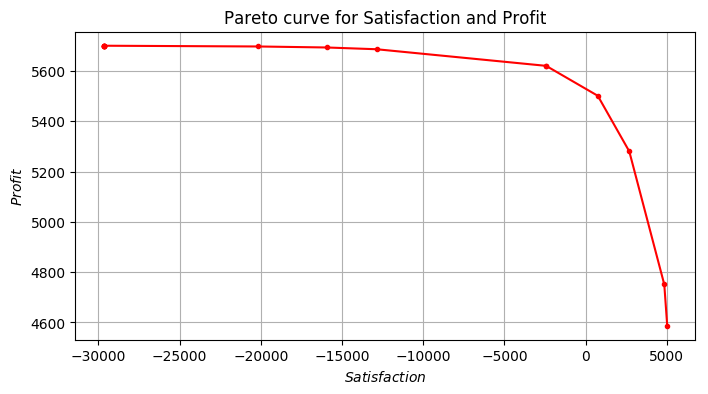

Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only
Academic license - for non-commercial use only


In [44]:
Npts = 15
Profit = zeros(Npts)
Satisfaction = zeros(Npts)

verbose = false

for (i,λ) in enumerate(logspace(-2,4,Npts))
    (Satisfaction[i],Profit[i],obj, assign) = solveopt2(100, 100, λ, 10000-λ)
    if (verbose)
        println("i: ", i)
        println(Budget[i])
        println(Profit[i])
    end
end;
using PyPlot
figure(figsize=(8,4))
plot( Satisfaction, Profit, "r.-" )
xlabel(L"Satisfaction")
ylabel(L"Profit");
title("Pareto curve for Satisfaction and Profit")
grid()

In [47]:
num_of_buildings = 10
building_loc=[]
for i in 1:num_of_buildings
    pos_x = rand(DiscreteUniform(-20, 20), num_of_buildings)
    pos_y = rand(DiscreteUniform(-20, 20), num_of_buildings)
    building_loc = hcat(pos_x, pos_y)
end;

λ=0
(a,b,c, assign) = solveopt2(100, 100, λ, 10000-λ);

Academic license - for non-commercial use only


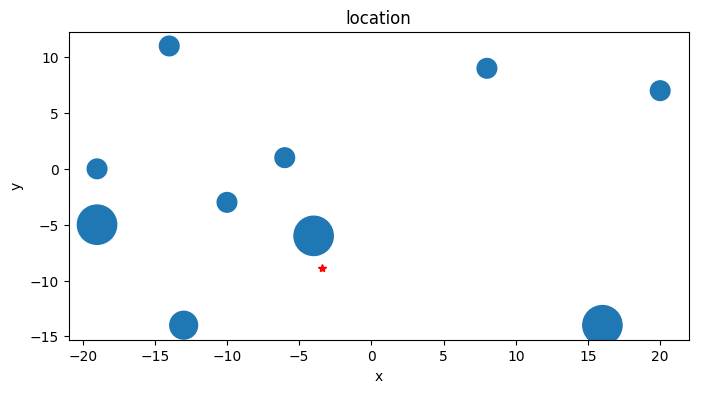

Academic license - for non-commercial use only


PyObject <matplotlib.text.Text object at 0x13e08dc50>

In [48]:
building_num = []
people_count=ones(1,10)

for i in 1:N
    push!(building_num, Int(sum(assign[i,:].*DormInfo[:,5])))
    people_count[Int(sum(assign[i,:].*DormInfo[:,5]))]+=1
end

using JuMP, Cbc, Gurobi
m = Model(solver = GurobiSolver(OutputFlag=0))

@variable(m, loc[1:2])

@expression(m, dist_sum, sum( (building_loc[building_num[i],1]-loc[1])^2+(building_loc[building_num[i],2]-loc[2])^2 for i=1:N))

@objective(m, Min, dist_sum)

state=solve(m)

using PyPlot
figure(figsize=(8,4));
scatter(building_loc[:,1], building_loc[:,2], s=people_count*200,alpha=1 );
x_result=getvalue(loc[1])
y_result=getvalue(loc[2])
plot(x_result, y_result, "r*" );
xlabel("x");
ylabel("y");
title("location")

# 4.	Results and Discussion

Through all the variables we've made, we decided to make λ1×Canteen-λ2×Floor+Budget to be satisfaction index, and the Income to be the profit UW-Madison made. We make a tradeoff between the satisfaction index and profit index so that and make a Pareto curve for Satisfaction and Profit. From the figure we could tell that the more satisfaction the students are, the less profit the univerisity could make. It makes sense because technically.

# 5.	Conclusion

In this model, we use a lot of expression to represent distinctive influence factor. In the beginning, we start to list the factor that could have an effect on the objective. Our basic idea is to find the least entropy where students can be adapted to an ideal dorm while enjoying the least enviornment factor from their imagination. So our project started from the constraints which stressed the relationship between students and dorm qualification. However, when we dealt with relationship between the students, it became a mystery that both Gurobi and Cbc couldn't solve. For example, we thought students may have some requirement on their dormate's time table, or students may expect their dormates to be in the same/different major, or to increase the diversity of the dorm, students with the same/different grades could be directed to the same room. However, when we actuallt went deeper into programming, it becomes desperate that Cbcsolver and Gurobisolver couldn't make it through and We later knew that it couldn't solver division NL program. Because we have to use the to calculate the mean of a dorm or entropy to figure out the chaos level, we had to calculate the sum of our variable(the dorm-student matrix).

then we decided to turn back to solving the tradeoffs to indicate the best optimal. In the first

setbacks  
The problem we have found is that if the seats that all dorms can provide get close to the number of the student, the change of trade coefficient λ doesn't actually make a fix towards the original distribution, which couldn't be optimally solved for times.

# 6.	Appendix